In [1]:
import utide

print(utide.__version__)

0.1b0.dev0


In [2]:
from datetime import datetime
from pandas import read_table, DataFrame

def date_parser(year, day, month, hour):
    year, day, month, hour = map(int, (year, day, month, hour))
    return datetime(year, day, month, hour)

parse_dates = dict(datetime=['year', 'month', 'day','hour'])

names = ['year', 'month', 'day', 'hour', 'elev', 'flag']

obs = read_table('can1998.dtf',
                 names=names,
                 skipinitialspace=True,
                 delim_whitespace=True,
                 index_col='datetime',
                 usecols=range(1, 7),
                 na_values='9.990',
                 parse_dates=parse_dates,
                 date_parser=date_parser)
obs.head(6)

,elev,flag
datetime,,
1998-01-01 00:00:00,1.20,0
1998-01-01 01:00:00,1.43,0
1998-01-01 02:00:00,1.73,0
1998-01-01 03:00:00,2.03,0
1998-01-01 04:00:00,2.38,0
1998-01-01 05:00:00,2.54,0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

bad = obs['flag'] == 2
corrected = obs['flag'] == 1

obs[bad] = np.NaN
obs['anomaly'] = obs['elev'] - obs['elev'].mean()
obs['anomaly'] = obs['anomaly'].interpolate()

In [4]:
from utide import solve
from matplotlib.dates import date2num

time = date2num(obs.index.to_pydatetime())

coef = solve(time, obs['anomaly'].values,
             lat=-25,
             method='ols',
             conf_int='linear')

solve: 
matrix prep ... 
Solution ...
diagnostics...
Done.



In [5]:
from utide import reconstruct

tide = reconstruct(time, coef)

reconstruct:
prep/calcs...
Done.



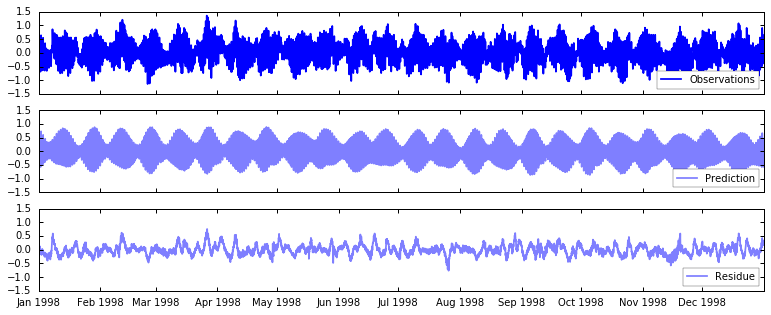

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-notebook')


fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(13, 5))

ax0.plot(obs.index, obs['anomaly'], label=u'Observations')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(obs.index, tide['h'], alpha=0.5, label=u'Prediction')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(obs.index, obs['anomaly']-tide['h'], alpha=0.5, label=u'Residue')
_ = ax2.legend(numpoints=1, loc='lower right')